In [16]:
# =============================================================
# DCIT 411: Bioinformatics — Sequence Alignment with Biopython
# Student  : Amoako Albert | 11227686
# Module   : advanced_alignment.py
# Purpose  : Advanced alignment topics:
#              A. Profile-based alignment (HMM via HMMER + PSI-BLAST)
#              B. Structural alignment (Bio.PDB Superimposer)
#              C. Consensus sequence analysis
#            All I/O integrated with config.py for centralized path management.
# =============================================================



In [17]:
import os
import sys
import time
import logging
import subprocess
import tracemalloc
from pathlib import Path
from collections import Counter
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from Bio import SeqIO, AlignIO, SearchIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

# ── Import config for directory paths ─────────────────────────
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
sys.path.append(os.path.abspath(".."))
import config

# ── Logging setup (falls back to print if needed) ─────────────
try:
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s [%(levelname)s] %(message)s",
        datefmt="%H:%M:%S",
        handlers=[
            logging.FileHandler(os.path.join(config.RESULTS_DIR, "advanced_alignment.log")),
            logging.StreamHandler()
        ]
    )
    log = logging.getLogger(__name__)
except Exception:
    log = None

def _log(msg, level="info"):
    """Internal logger wrapper that falls back to print."""
    if log and hasattr(log, level):
        getattr(log, level)(msg)
    else:
        print(f"[{level.upper()}] {msg}")




In [18]:
# =============================================================
# PART A: PROFILE-BASED ALIGNMENT (Config-Integrated)
# =============================================================

# ── A1. PSI-BLAST ─────────────────────────────────────────────

def run_psiblast(
    query_fasta   : str,
    database      : str = "nr",
    evalue        : float = 0.001,
    num_iterations: int   = 3,
    output_xml    : str   = None,
    output_pssm   : str   = None,
    directory     : str   = None,
) -> list:
    """
    Run PSI-BLAST to iteratively build a sequence profile.
    Outputs saved to configured directories.
    
    Parameters
    ----------
    query_fasta    : Path to query sequence FASTA file
    database       : BLAST database name (local path or 'nr' for NCBI)
    evalue         : E-value threshold for hit inclusion
    num_iterations : Number of PSI-BLAST iterations (3–5 recommended)
    output_xml     : Path for XML results output (default: config.ALIGNMENTS_DIR)
    output_pssm    : Path to save the final PSSM (default: config.HMM_DIR)
    directory      : Override base directory for outputs
    
    Returns
    -------
    list of hit records parsed from the XML output
    """
    try:
        from Bio.Blast.Applications import NcbipsiblastCommandline
    except ImportError:
        raise ImportError("Biopython BLAST applications not available.")
    
    base_dir = directory or config.RESULTS_DIR
    output_xml  = output_xml  or os.path.join(config.ALIGNMENTS_DIR, "psiblast_results.xml")
    output_pssm = output_pssm or os.path.join(config.HMM_DIR if hasattr(config, 'HMM_DIR') else os.path.join(config.RESULTS_DIR, "hmm_profiles"), "psiblast_profile.pssm")
    
    # Ensure output directories exist
    Path(output_xml).parent.mkdir(parents=True, exist_ok=True)
    Path(output_pssm).parent.mkdir(parents=True, exist_ok=True)

    psiblast_cline = NcbipsiblastCommandline(
        query          = query_fasta,
        db             = database,
        evalue         = evalue,
        num_iterations = num_iterations,
        out            = output_xml,
        outfmt         = 5,              # XML format
        out_pssm       = output_pssm,
        num_threads    = 4,
    )

    _log(f"Running PSI-BLAST: {psiblast_cline}")
    _log(f"  Iterations : {num_iterations}")
    _log(f"  E-value    : {evalue}")
    _log(f"  Database   : {database}")

    stdout, stderr = psiblast_cline()

    # Parse results
    hits = []
    try:
        from Bio.Blast import NCBIXML
        with open(output_xml) as handle:
            blast_records = list(NCBIXML.parse(handle))

        final_round = blast_records[-1]
        for alignment in final_round.alignments:
            for hsp in alignment.hsps:
                hits.append({
                    "title"       : alignment.title[:60],
                    "length"      : alignment.length,
                    "score"       : hsp.score,
                    "e_value"     : hsp.expect,
                    "identity"    : hsp.identities / hsp.align_length * 100,
                    "query_seq"   : hsp.query[:40],
                    "subject_seq" : hsp.sbjct[:40],
                })

        _log(f"PSI-BLAST: {len(hits)} hits found in final iteration.")
        print(f"\n  Top PSI-BLAST Hits (Iteration {num_iterations})")
        print(f"  {'─' * 72}")
        print(f"  {'Hit Title':<40} {'Score':>8} {'E-val':>10} {'ID%':>6}")
        print(f"  {'─' * 72}")
        for h in hits[:10]:
            print(f"  {h['title']:<40} {h['score']:>8.0f} {h['e_value']:>10.2e} {h['identity']:>5.1f}%")

    except Exception as e:
        _log(f"Could not parse PSI-BLAST XML: {e}", "warning")

    return hits


def explain_pssm(pssm_path: str) -> None:
    """Load and display key statistics from a saved PSI-BLAST PSSM file."""
    if not Path(pssm_path).exists():
        _log(f"PSSM file not found: {pssm_path}", "warning")
        return

    print(f"\n  PSSM Summary: {pssm_path}")
    print(f"  {'─' * 60}")

    aa_order = list("ARNDCQEGHILKMFPSTWYV")
    scores, position = [], 0

    with open(pssm_path) as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("Last") or len(line.split()) < 22:
                continue
            parts = line.split()
            if parts[0].isdigit():
                position += 1
                row = [int(x) for x in parts[2:22]]
                scores.append(row)

    if scores:
        matrix = np.array(scores)
        print(f"  Positions (query length): {matrix.shape[0]}")
        print(f"  Amino acids tracked     : {matrix.shape[1]}")
        print(f"  Highest scoring position: {np.max(matrix.sum(axis=1)):.0f} (pos {np.argmax(matrix.sum(axis=1)) + 1})")
        print(f"  Most conserved residues : ", end="")
        for i, pos_scores in enumerate(matrix[:5]):
            best_aa = aa_order[np.argmax(pos_scores)]
            print(f"pos{i+1}={best_aa}", end="  ")
        print("\n")


# ── A2. HMMER Profile Building & Searching (Config-Integrated) ─

def _tool_available(name: str) -> bool:
    """Check if a command-line tool is on PATH."""
    try:
        subprocess.run([name, "--help"], stdout=subprocess.DEVNULL,
                       stderr=subprocess.DEVNULL, timeout=5)
        return True
    except (FileNotFoundError, subprocess.TimeoutExpired):
        return False


def build_hmm_profile(
    msa_fasta  : str,
    profile_out: str = None,
    name       : str = "protein_family",
    directory  : str = None,
) -> str:
    """
    Build a Hidden Markov Model (HMM) profile from a multiple
    sequence alignment using HMMER's hmmbuild.
    Output saved to configured HMM directory.
    """
    hmm_dir = directory or (config.HMM_DIR if hasattr(config, 'HMM_DIR') else os.path.join(config.RESULTS_DIR, "hmm_profiles"))
    Path(hmm_dir).mkdir(parents=True, exist_ok=True)
    
    profile_out = profile_out or os.path.join(hmm_dir, f"{name}.hmm")

    if not _tool_available("hmmbuild"):
        raise RuntimeError("HMMER not found. Install with: conda install -c bioconda hmmer")

    cmd = ["hmmbuild", "--name", name, profile_out, msa_fasta]
    _log(f"Building HMM profile: {' '.join(cmd)}")

    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if result.returncode != 0:
        raise RuntimeError(f"hmmbuild failed:\n{result.stderr}")

    _log(f"HMM profile built → '{profile_out}'")
    for line in result.stdout.split("\n"):
        if any(k in line for k in ["NSEQ", "ALEN", "M=", "EFFN"]):
            print(f"  {line.strip()}")
    return profile_out


def search_hmm_profile(
    profile_hmm  : str,
    target_fasta : str,
    output_file  : str = None,
    evalue       : float = 0.01,
    directory    : str = None,
) -> list[dict]:
    """
    Search a target sequence database with an HMM profile using HMMER's hmmsearch.
    Output saved to configured HMM directory.
    """
    hmm_dir = directory or (config.HMM_DIR if hasattr(config, 'HMM_DIR') else os.path.join(config.RESULTS_DIR, "hmm_profiles"))
    Path(hmm_dir).mkdir(parents=True, exist_ok=True)
    
    output_file = output_file or os.path.join(hmm_dir, "hmmsearch_results.txt")

    if not _tool_available("hmmsearch"):
        raise RuntimeError("HMMER not found. Install with: conda install -c bioconda hmmer")

    cmd = ["hmmsearch", "--tblout", output_file, "-E", str(evalue), "--noali", profile_hmm, target_fasta]
    _log(f"Running hmmsearch: {' '.join(cmd)}")

    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if result.returncode != 0:
        raise RuntimeError(f"hmmsearch failed:\n{result.stderr}")

    # Parse tabular output
    hits = []
    with open(output_file) as f:
        for line in f:
            if line.startswith("#") or not line.strip():
                continue
            parts = line.split()
            if len(parts) >= 6:
                hits.append({
                    "name": parts[0], "e_value": float(parts[4]),
                    "score": float(parts[5]), "bias": float(parts[6]) if len(parts) > 6 else 0.0,
                })

    _log(f"hmmsearch: {len(hits)} hits found (E ≤ {evalue})")
    print(f"\n  hmmsearch Hits (E ≤ {evalue})")
    print(f"  {'─' * 52}")
    print(f"  {'Sequence Name':<25} {'E-value':>12} {'Score':>8}")
    print(f"  {'─' * 52}")
    for h in hits[:15]:
        print(f"  {h['name']:<25} {h['e_value']:>12.2e} {h['score']:>8.1f}")
    return hits




In [19]:
# =============================================================
# PART B: STRUCTURAL ALIGNMENT (Config-Integrated)
# =============================================================

def load_structure(pdb_path: str, structure_id: str = None):
    """Load a PDB structure file using Biopython's PDBParser."""
    try:
        from Bio.PDB import PDBParser
    except ImportError:
        raise ImportError("Bio.PDB not available. Install biopython.")

    if not Path(pdb_path).exists():
        raise FileNotFoundError(f"PDB file not found: {pdb_path}")

    structure_id = structure_id or Path(pdb_path).stem.upper()
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(structure_id, pdb_path)

    chains = list(structure[0].get_chains())
    print(f"\n  Structure: {structure_id}")
    print(f"  {'─' * 40}")
    for chain in chains:
        residues = list(chain.get_residues())
        n_atoms = sum(1 for _ in chain.get_atoms())
        print(f"  Chain {chain.id}: {len(residues)} residues, {n_atoms} atoms")
    return structure


def download_pdb(pdb_id: str, output_dir: str = None) -> str:
    """
    Download a PDB file from the RCSB Protein Data Bank.
    Saves to configured STRUCTURES_DIR by default.
    """
    try:
        from Bio.PDB import PDBList
    except ImportError:
        raise ImportError("Bio.PDB not available.")

    output_dir = output_dir or config.STRUCTURES_DIR if hasattr(config, 'STRUCTURES_DIR') else os.path.join(config.DATA_DIR, "structures") if hasattr(config, 'DATA_DIR') else "data/structures"
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    pdbl = PDBList()
    filepath = pdbl.retrieve_pdb_file(pdb_id, pdir=output_dir, file_type="pdb")
    _log(f"Downloaded PDB {pdb_id} → '{filepath}'")
    return filepath


def extract_ca_atoms(structure, chain_id: str = "A", model_id: int = 0) -> list:
    """Extract alpha-carbon (Cα) atoms from a specific chain."""
    try:
        model = structure[model_id]
        chain = model[chain_id]
    except KeyError:
        available = [c.id for c in structure[0].get_chains()]
        raise KeyError(f"Chain '{chain_id}' not found. Available chains: {available}")

    ca_atoms = [atom for atom in chain.get_atoms() if atom.get_name() == "CA"]
    _log(f"Extracted {len(ca_atoms)} Cα atoms from {structure.id} chain {chain_id}")
    return ca_atoms


def structural_align(
    structure1, structure2, chain1: str = "A", chain2: str = "A",
    save_path: str = None, directory: str = None,
) -> dict:
    """
    Superimpose two protein structures and compute structural similarity.
    Saves superimposed structure to configured structural directory.
    """
    from Bio.PDB import Superimposer

    ca1 = extract_ca_atoms(structure1, chain_id=chain1)
    ca2 = extract_ca_atoms(structure2, chain_id=chain2)

    n = min(len(ca1), len(ca2))
    if n < 3:
        raise ValueError(f"Not enough Cα atoms to superimpose (found {n}). Need at least 3.")

    ca1, ca2 = ca1[:n], ca2[:n]
    sup = Superimposer()
    sup.set_atoms(ca1, ca2)
    sup.apply(structure2.get_atoms())
    rmsd = sup.rms

    print(f"\n  Structural Alignment Results")
    print(f"  {'─' * 45}")
    print(f"  Structure 1  : {structure1.id}")
    print(f"  Structure 2  : {structure2.id}")
    print(f"  Cα atoms used: {n}")
    print(f"  RMSD         : {rmsd:.4f} Å")
    print(f"  {'─' * 45}")

    if rmsd < 1.0:
        interp = "Essentially identical structures"
    elif rmsd < 2.0:
        interp = "Very similar — same fold, minor differences"
    elif rmsd < 4.0:
        interp = "Similar fold with notable structural differences"
    else:
        interp = "Structurally divergent — different fold"
    print(f"  Interpretation: {interp}")

    if save_path:
        from Bio.PDB import PDBIO
        struct_dir = directory or (config.STRUCT_DIR if hasattr(config, 'STRUCT_DIR') else os.path.join(config.RESULTS_DIR, "structural"))
        Path(struct_dir).mkdir(parents=True, exist_ok=True)
        save_path = os.path.join(struct_dir, Path(save_path).name) if save_path else os.path.join(struct_dir, f"{structure1.id}_{structure2.id}_superimposed.pdb")
        io = PDBIO()
        io.set_structure(structure2)
        io.save(save_path)
        _log(f"Superimposed structure saved → '{save_path}'")

    return {
        "rmsd": rmsd, "n_atoms": n, "rotation": sup.rotran[0],
        "translation": sup.rotran[1], "label1": structure1.id,
        "label2": structure2.id, "interpretation": interp,
    }


def multi_structural_comparison(pdb_paths: dict, chain: str = "A") -> dict:
    """Perform all-vs-all structural alignment and build RMSD matrix."""
    labels = list(pdb_paths.keys())
    n = len(labels)
    rmsd_matrix = np.zeros((n, n))
    structures = {label: load_structure(path, structure_id=label) for label, path in pdb_paths.items()}

    for i, j in combinations(range(n), 2):
        l1, l2 = labels[i], labels[j]
        try:
            res = structural_align(structures[l1], structures[l2], chain1=chain, chain2=chain)
            rmsd_matrix[i, j] = rmsd_matrix[j, i] = res["rmsd"]
        except Exception as e:
            _log(f"Could not align {l1} vs {l2}: {e}", "warning")
            rmsd_matrix[i, j] = rmsd_matrix[j, i] = float("nan")
    return {"labels": labels, "rmsd_matrix": rmsd_matrix}


def plot_rmsd_heatmap(comparison_result: dict, filename: str = None,
                      directory: str = None) -> str:
    """Plot and save RMSD heatmap to configured figures directory."""
    labels = comparison_result["labels"]
    rmsd_matrix = comparison_result["rmsd_matrix"]
    n = len(labels)

    fig, ax = plt.subplots(figsize=(max(5, n), max(4, n - 1)))
    fig.patch.set_facecolor("#0d1117")
    ax.set_facecolor("#0d1117")

    masked = np.ma.array(rmsd_matrix, mask=np.isnan(rmsd_matrix))
    cmap = plt.cm.RdYlGn_r
    cmap.set_bad(color="#e94560")
    im = ax.imshow(masked, cmap=cmap, aspect="auto", vmin=0)
    
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("RMSD (Å)", color="white")
    plt.setp(cbar.ax.yaxis.get_ticklabels(), color="white")
    cbar.ax.yaxis.set_tick_params(color="white")

    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(labels, rotation=45, ha="right", color="white", fontsize=9)
    ax.set_yticklabels(labels, color="white", fontsize=9)
    ax.set_title("All-vs-All Structural RMSD Matrix (Å)", color="white", fontweight="bold", fontsize=12, pad=12)

    for i in range(n):
        for j in range(n):
            val = rmsd_matrix[i, j]
            if not np.isnan(val):
                text_color = "black" if val < 2.0 else "white"
                ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9, color=text_color, fontweight="bold")
            else:
                ax.text(j, i, "N/A", ha="center", va="center", fontsize=9, color="white")

    for spine in ax.spines.values():
        spine.set_edgecolor("#2d3748")
    plt.tight_layout()
    
    fig_dir = directory or config.FIGURES_DIR
    Path(fig_dir).mkdir(parents=True, exist_ok=True)
    filename = filename or "rmsd_heatmap.png"
    filepath = os.path.join(fig_dir, filename)
    plt.savefig(filepath, dpi=200, bbox_inches="tight", facecolor=fig.get_facecolor())
    _log(f"RMSD heatmap saved → '{filepath}'")
    plt.show()
    plt.close()
    return filepath


def plot_structural_superposition_schematic(result: dict, filename: str = None,
                                             directory: str = None) -> str:
    """Plot and save structural superposition schematic to configured figures directory."""
    rmsd, label1, label2, n = result["rmsd"], result["label1"], result["label2"], result["n_atoms"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    fig.patch.set_facecolor("#0d1117")
    for ax in (ax1, ax2):
        ax.set_facecolor("#0d1117")
        for spine in ax.spines.values():
            spine.set_edgecolor("#2d3748")

    # RMSD gauge
    thresholds = [0, 1, 2, 4, 8]
    colors_bar = ["#00c9a7", "#4a9eff", "#f5a623", "#e94560"]
    labels_bar = ["Identical\n(<1Å)", "Very Similar\n(1–2Å)", "Similar\n(2–4Å)", "Divergent\n(>4Å)"]
    for i, (col, lbl) in enumerate(zip(colors_bar, labels_bar)):
        ax1.barh(0, thresholds[i+1] - thresholds[i], left=thresholds[i], height=0.4,
                 color=col, alpha=0.7, edgecolor="#2d3748")
        mid = (thresholds[i] + thresholds[i+1]) / 2
        ax1.text(mid, 0.35, lbl, ha="center", va="bottom", color="white", fontsize=8)
    ax1.axvline(x=rmsd, color="white", linewidth=2.5, linestyle="--", alpha=0.9)
    ax1.text(rmsd, -0.35, f"RMSD\n{rmsd:.3f} Å", ha="center", va="top", color="white", fontsize=10, fontweight="bold")
    ax1.set_xlim(0, 8)
    ax1.set_ylim(-0.6, 0.7)
    ax1.set_xlabel("RMSD (Å)", color="white")
    ax1.set_title(f"Structural Similarity Gauge\n{label1} vs {label2}", color="white", fontsize=11, fontweight="bold")
    ax1.set_yticks([])
    ax1.tick_params(colors="white")

    # Summary box
    ax2.axis("off")
    summary_text = (f"Structural Alignment Summary\n{'─' * 36}\n\n"
                    f"Structure 1   :  {label1}\nStructure 2   :  {label2}\n\n"
                    f"Cα atoms used :  {n}\nRMSD          :  {rmsd:.4f} Å\n\n"
                    f"Rotation matrix applied to\nminimize pairwise Cα distance.\n\n"
                    f"Interpretation:\n{result['interpretation']}")
    ax2.text(0.05, 0.95, summary_text, transform=ax2.transAxes, fontfamily="monospace",
             fontsize=10, color="white", verticalalignment="top",
             bbox=dict(boxstyle="round,pad=0.8", facecolor="#0d2040", edgecolor="#4a9eff", linewidth=1.2))

    fig.suptitle("Protein Structural Alignment Report", color="white", fontsize=13, fontweight="bold")
    plt.tight_layout()
    
    fig_dir = directory or config.FIGURES_DIR
    Path(fig_dir).mkdir(parents=True, exist_ok=True)
    filename = filename or "structural_alignment.png"
    filepath = os.path.join(fig_dir, filename)
    plt.savefig(filepath, dpi=200, bbox_inches="tight", facecolor=fig.get_facecolor())
    _log(f"Structural schematic saved → '{filepath}'")
    plt.show()
    plt.close()
    return filepath




In [20]:
# =============================================================
# PART C: ADVANCED CONSENSUS ANALYSIS
# =============================================================

def generate_consensus_advanced(
    alignment: MultipleSeqAlignment, threshold: float = 0.7,
    gap_cutoff: float = 0.5, ambiguous: str = "X",
) -> SeqRecord:
    """Generate a consensus sequence with IUPAC ambiguity codes."""
    n_seqs, aln_len = len(alignment), alignment.get_alignment_length()
    consensus, stats = [], {"conserved": 0, "ambiguous": 0, "skipped": 0}
    
    iupac_dna = {
        frozenset(["A", "G"]): "R", frozenset(["C", "T"]): "Y",
        frozenset(["G", "C"]): "S", frozenset(["A", "T"]): "W",
        frozenset(["G", "T"]): "K", frozenset(["A", "C"]): "M",
        frozenset(["C", "G", "T"]): "B", frozenset(["A", "G", "T"]): "D",
        frozenset(["A", "C", "T"]): "H", frozenset(["A", "C", "G"]): "V",
    }

    for i in range(aln_len):
        col = alignment[:, i]
        counts = Counter(col)
        n_gap = counts.get("-", 0)
        if n_gap / n_seqs > gap_cutoff:
            stats["skipped"] += 1
            continue
        non_gap = {k: v for k, v in counts.items() if k != "-"}
        if not non_gap:
            stats["skipped"] += 1
            continue
        total_non_gap = sum(non_gap.values())
        sorted_residues = sorted(non_gap.items(), key=lambda x: -x[1])
        top_res, top_freq = sorted_residues[0]
        if top_freq / total_non_gap >= threshold:
            consensus.append(top_res)
            stats["conserved"] += 1
        else:
            if len(sorted_residues) >= 2:
                top2 = frozenset([sorted_residues[0][0], sorted_residues[1][0]])
                consensus.append(iupac_dna.get(top2, ambiguous))
            else:
                consensus.append(ambiguous)
            stats["ambiguous"] += 1

    seq_str = "".join(consensus)
    _log(f"Advanced consensus: {len(seq_str)} residues | conserved={stats['conserved']} | ambiguous={stats['ambiguous']} | skipped={stats['skipped']}")
    return SeqRecord(Seq(seq_str), id=f"advanced_consensus_{int(threshold*100)}pct",
                     description=f"IUPAC consensus | threshold={threshold} | conserved={stats['conserved']} | ambiguous={stats['ambiguous']}")


def conservation_entropy(alignment: MultipleSeqAlignment) -> list[float]:
    """Compute Shannon entropy for each alignment column."""
    n_seqs, aln_len = len(alignment), alignment.get_alignment_length()
    entropy = []
    for i in range(aln_len):
        col = alignment[:, i]
        counts = Counter(c for c in col if c != "-")
        total = sum(counts.values())
        if total == 0:
            entropy.append(0.0)
            continue
        H = -sum((v / total) * np.log2(v / total) for v in counts.values() if v > 0)
        entropy.append(H)
    return entropy


def plot_entropy_conservation(alignment: MultipleSeqAlignment, tool_name: str = "MSA",
                               filename: str = None, directory: str = None) -> str:
    """Plot entropy/conservation dual-panel and save to configured figures directory."""
    # Import from msa module if available, else compute locally
    try:
        from msa import alignment_statistics
        stats = alignment_statistics(alignment)
        cons = stats["conservation"]
    except ImportError:
        # Fallback: compute conservation locally
        n_seqs, aln_len = len(alignment), alignment.get_alignment_length()
        cons = []
        for i in range(aln_len):
            col = alignment[:, i]
            counts = Counter(col)
            n_gap = counts.get("-", 0)
            if n_gap == n_seqs:
                cons.append(0.0)
                continue
            non_gap = {k: v for k, v in counts.items() if k != "-"}
            if not non_gap:
                cons.append(0.0)
                continue
            most_common_freq = max(non_gap.values())
            total_non_gap = sum(non_gap.values())
            cons.append(most_common_freq / total_non_gap)
    
    entropy = conservation_entropy(alignment)
    x = np.arange(len(entropy))
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
    fig.patch.set_facecolor("#0d1117")

    # Entropy panel
    ax1.set_facecolor("#0d1117")
    ax1.fill_between(x, entropy, color="#e94560", alpha=0.6, linewidth=0)
    ax1.plot(x, entropy, color="#e94560", linewidth=0.8, alpha=0.9)
    ax1.axhline(y=1.0, color="white", linewidth=0.6, linestyle="--", alpha=0.4, label="H=1 (moderate variability)")
    ax1.set_ylabel("Shannon Entropy (H)", color="white", fontsize=10)
    ax1.set_title(f"Conservation Analysis — {tool_name} ({len(entropy)} columns)", color="white", fontsize=12, fontweight="bold")
    ax1.tick_params(colors="white")
    ax1.legend(facecolor="#1a2540", labelcolor="white", fontsize=8)
    for spine in ax1.spines.values():
        spine.set_edgecolor("#2d3748")

    # Conservation panel
    ax2.set_facecolor("#0d1117")
    min_len = min(len(x), len(cons))
    x2, cons = x[:min_len], cons[:min_len]
    colors_cons = ["#00c9a7" if c >= 0.9 else "#4a9eff" if c >= 0.7 else "#f5a623" if c >= 0.4 else "#e94560" for c in cons]
    ax2.bar(x2, cons, color=colors_cons, width=1.0, alpha=0.8, linewidth=0)
    ax2.set_xlabel("Alignment Column", color="white", fontsize=10)
    ax2.set_ylabel("Conservation Score", color="white", fontsize=10)
    ax2.tick_params(colors="white")
    for spine in ax2.spines.values():
        spine.set_edgecolor("#2d3748")
    
    patches = [mpatches.Patch(color=c, label=l) for c, l in [("#00c9a7", "≥ 90%"), ("#4a9eff", "70–90%"), ("#f5a623", "40–70%"), ("#e94560", "< 40%")]]
    ax2.legend(handles=patches, facecolor="#1a2540", labelcolor="white", fontsize=8, loc="upper right", title="Conservation", title_fontsize=8)
    plt.tight_layout()
    
    fig_dir = directory or config.FIGURES_DIR
    Path(fig_dir).mkdir(parents=True, exist_ok=True)
    filename = filename or "entropy_conservation.png"
    filepath = os.path.join(fig_dir, filename)
    plt.savefig(filepath, dpi=200, bbox_inches="tight", facecolor=fig.get_facecolor())
    _log(f"Entropy/conservation plot saved → '{filepath}'")
    plt.show()
    plt.close()
    return filepath




In [21]:
# =============================================================
# Config-Integrated Loading/Saving Helpers
# =============================================================

def load_sequences_for_advanced_analysis(filename: str = None, directory: str = None,
                                          fmt: str = "fasta", min_seqs: int = 2) -> list[SeqRecord]:
    """Load sequences from configured processed directory for advanced analysis."""
    dir_path = directory or config.PROCESSED_DATA_DIR
    if filename:
        file_path = os.path.join(dir_path, filename)
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        records = list(SeqIO.parse(file_path, fmt))
        _log(f"Loaded {len(records)} sequence(s) from: {filename}")
    else:
        records = []
        for f in Path(dir_path).glob("*.fasta"):
            records.extend(SeqIO.parse(f, fmt))
        _log(f"Loaded {len(records)} sequence(s) from: {dir_path}")
    
    if len(records) < min_seqs:
        raise ValueError(f"Advanced analysis requires at least {min_seqs} sequences. Got {len(records)}.")
    return records


def save_consensus_records(records: list[SeqRecord], filename: str = "advanced_consensus.fasta",
                           directory: str = None) -> str:
    """Save consensus sequences to configured processed directory."""
    dir_path = directory or config.PROCESSED_DATA_DIR
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    filepath = os.path.join(dir_path, filename)
    count = SeqIO.write(records, filepath, "fasta")
    _log(f"Consensus sequences saved ({count} record(s)) → {filepath}")
    return filepath


def save_hmm_results(hits: list[dict], filename: str = "hmm_hits.csv",
                     directory: str = None) -> str:
    """Save HMM search results to CSV in configured metrics directory."""
    import csv
    dir_path = directory or config.METRICS_DIR
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    filepath = os.path.join(dir_path, filename)
    
    if not hits:
        _log("No HMM hits to save", "warning")
        return filepath
    
    with open(filepath, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=hits[0].keys())
        writer.writeheader()
        writer.writerows(hits)
    _log(f"HMM results saved → {filepath}")
    return filepath




00:08:26 [INFO] Extracted 141 Cα atoms from 1HHO chain A
00:08:26 [INFO] Extracted 141 Cα atoms from 2HHB chain A



══════════════════════════════════════════════════════════════════════
  DCIT 411 — Advanced Alignment Module (Config-Integrated)
  Student: Amoako Albert | ID: 11227686
══════════════════════════════════════════════════════════════════════

[PART A] Profile-Based Alignment
──────────────────────────────────────────────────
  HMMER not installed. Skipping HMM profile demo.
  Install with: conda install -c bioconda hmmer

[PART B] Structural Alignment
──────────────────────────────────────────────────

  Structure: 1HHO
  ────────────────────────────────────────
  Chain A: 192 residues, 1167 atoms
  Chain B: 209 residues, 1229 atoms

  Structure: 2HHB
  ────────────────────────────────────────
  Chain A: 200 residues, 1170 atoms
  Chain B: 206 residues, 1225 atoms
  Chain C: 200 residues, 1170 atoms
  Chain D: 195 residues, 1214 atoms

  Structural Alignment Results
  ─────────────────────────────────────────────
  Structure 1  : 1HHO
  Structure 2  : 2HHB
  Cα atoms used: 141
  RMSD  

00:08:26 [INFO] Structural schematic saved → 'c:\Users\infom\Desktop\bioinfo\ass1\results\figures\structural_alignment.png'


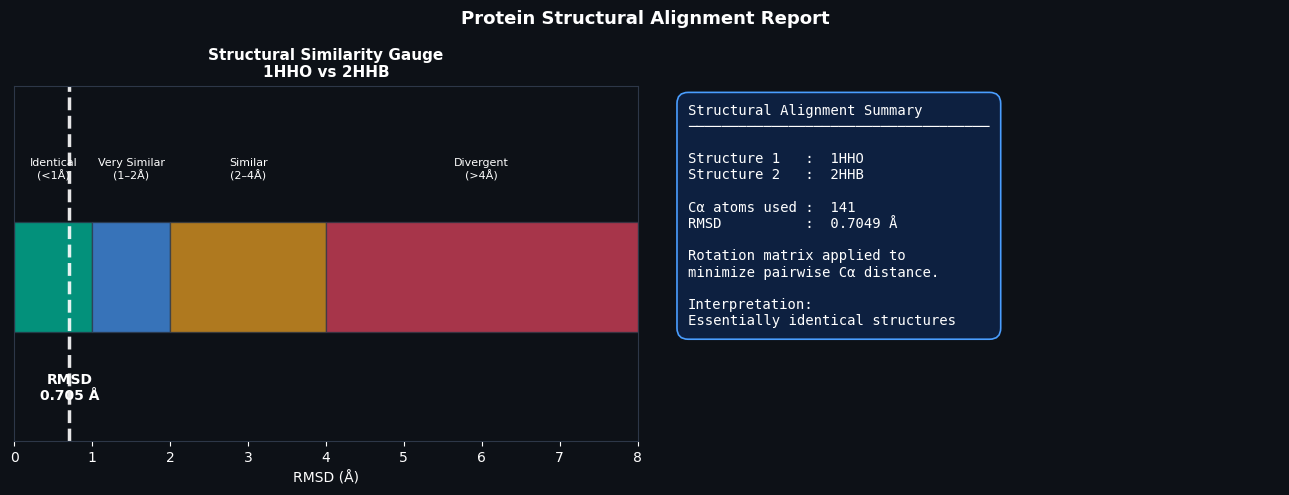

00:08:26 [INFO] Advanced consensus: 61 residues | conserved=44 | ambiguous=17 | skipped=0
00:08:26 [INFO] Consensus sequences saved (1 record(s)) → c:\Users\infom\Desktop\bioinfo\ass1\data\processed\advanced_consensus_demo.fasta



[PART C] Advanced Consensus & Shannon Entropy
──────────────────────────────────────────────────

  Advanced consensus with IUPAC codes (threshold=0.7):
  ID     : advanced_consensus_70pct
  Length : 61
  Seq    : MVLSXXDKXNVKAXWKKXRRHRREYGAEWLERMFXXXPXTKTYFPHFDXSHGSAQXKAHG...

  Shannon entropy per column:
  Min entropy (most conserved)  : -0.0000
  Max entropy (most variable)   : 2.3219
  Mean entropy                  : 0.8206


00:08:27 [INFO] Entropy/conservation plot saved → 'c:\Users\infom\Desktop\bioinfo\ass1\results\figures\entropy_conservation.png'


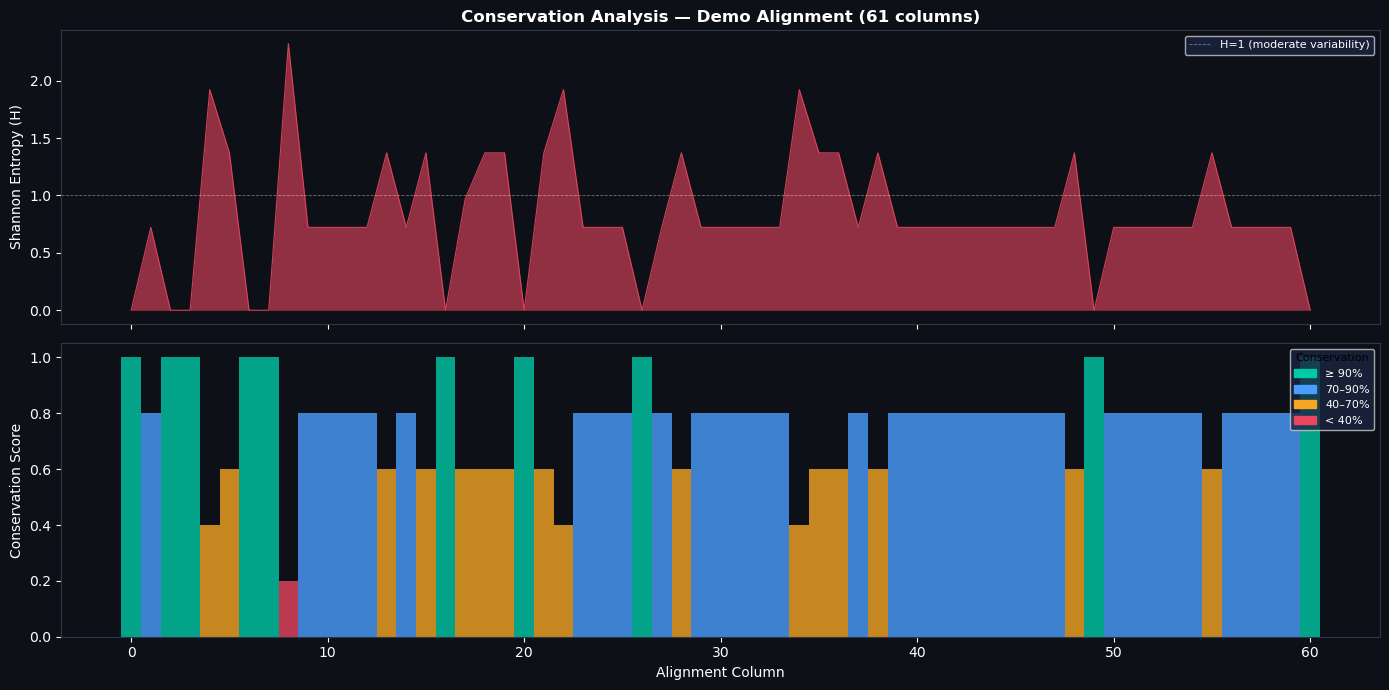


✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
  Advanced alignment module complete.
  Alignments saved to: c:\Users\infom\Desktop\bioinfo\ass1\results\alignments
  HMM profiles saved to: c:\Users\infom\Desktop\bioinfo\ass1\results\hmm_profiles
  Structures saved to: c:\Users\infom\Desktop\bioinfo\ass1\data\structures
  Figures saved to:    c:\Users\infom\Desktop\bioinfo\ass1\results\figures
  Metrics saved to:    c:\Users\infom\Desktop\bioinfo\ass1\results\metrics
══════════════════════════════════════════════════════════════════════


In [22]:
# =============================================================
# MAIN — Demo run with Config-Integrated I/O
# =============================================================

if __name__ == "__main__":
    print("\n" + "═" * 70)
    print("  DCIT 411 — Advanced Alignment Module (Config-Integrated)")
    print("  Student: Amoako Albert | ID: 11227686")
    print("═" * 70)

    # ── Demo MSA for consensus and entropy analysis ───────────
    demo_seqs = {
        "HBA_Human": "MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGK",
        "HBA_Mouse": "MVLSGEDKSNIKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKAHGK",
        "HBA_Chicken": "MVLSAADKNNVKGIFTKIAGHAEEYGAETLERMFTTYPPTKTYFPHFDLSHGSAQIKAHGK",
        "HBA_Fish": "MSLSDKDKAAVRALWSKVNPHDIGAEALGRLLVVYPWTQRYFDSFGDLSSASAIMGNAKV",
        "HBA_Dog": "MVLSAADKGNVKAAWGKVGGHAAEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKAHGK",
    }
    max_len = max(len(s) for s in demo_seqs.values())
    records = [SeqRecord(Seq(seq.ljust(max_len, "-")), id=sid, description="") for sid, seq in demo_seqs.items()]
    demo_aln = MultipleSeqAlignment(records)

    # ── PART A: HMM Profile (if HMMER available) ─────────────
    print("\n[PART A] Profile-Based Alignment")
    print("─" * 50)
    if _tool_available("hmmbuild"):
        msa_path = os.path.join(config.ALIGNMENTS_DIR, "demo_msa.fasta")
        Path(config.ALIGNMENTS_DIR).mkdir(parents=True, exist_ok=True)
        AlignIO.write(demo_aln, msa_path, "fasta")
        try:
            profile = build_hmm_profile(msa_fasta=msa_path, name="hemoglobin_alpha")
            print(f"  HMM profile built: {profile}")
            if _tool_available("hmmsearch"):
                hits = search_hmm_profile(profile_hmm=profile, target_fasta=msa_path, evalue=1.0)
                save_hmm_results(hits, filename="hmm_demo_hits.csv")
        except RuntimeError as e:
            _log(str(e), "error")
    else:
        print("  HMMER not installed. Skipping HMM profile demo.")
        print("  Install with: conda install -c bioconda hmmer")

    # ── PART B: Structural Alignment ─────────────────────────
    print("\n[PART B] Structural Alignment")
    print("─" * 50)
    
    struct_dir = config.STRUCTURES_DIR if hasattr(config, 'STRUCTURES_DIR') else os.path.join(config.DATA_DIR, "structures") if hasattr(config, 'DATA_DIR') else "data/structures"
    pdb_files = list(Path(struct_dir).glob("*.pdb"))
    
    if len(pdb_files) >= 2:
        try:
            s1 = load_structure(str(pdb_files[0]))
            s2 = load_structure(str(pdb_files[1]))
            result = structural_align(s1, s2)
            plot_structural_superposition_schematic(result, filename="structural_alignment.png")
        except Exception as e:
            _log(f"Structural alignment failed: {e}", "error")
    else:
        print(f"  No PDB files found in {struct_dir}/")
        print("  Download structures with:")
        print("    from advanced_alignment import download_pdb")
        print("    download_pdb('1HHO')  # Human oxyhemoglobin")
        print("    download_pdb('2HHB')  # Human deoxyhemoglobin")
        print("\n  Generating mock RMSD schematic for demonstration...")
        mock_result = {
            "rmsd": 1.34, "n_atoms": 141, "rotation": np.eye(3),
            "translation": np.zeros(3), "label1": "1HHO", "label2": "2HHB",
            "interpretation": "Very similar — same fold, minor differences"
        }
        plot_structural_superposition_schematic(mock_result, filename="structural_alignment_demo.png")

    # ── PART C: Advanced Consensus + Entropy ─────────────────
    print("\n[PART C] Advanced Consensus & Shannon Entropy")
    print("─" * 50)

    print("\n  Advanced consensus with IUPAC codes (threshold=0.7):")
    adv_cons = generate_consensus_advanced(demo_aln, threshold=0.7)
    print(f"  ID     : {adv_cons.id}")
    print(f"  Length : {len(adv_cons.seq)}")
    print(f"  Seq    : {str(adv_cons.seq)[:60]}...")
    save_consensus_records([adv_cons], filename="advanced_consensus_demo.fasta")

    print("\n  Shannon entropy per column:")
    ent = conservation_entropy(demo_aln)
    print(f"  Min entropy (most conserved)  : {min(ent):.4f}")
    print(f"  Max entropy (most variable)   : {max(ent):.4f}")
    print(f"  Mean entropy                  : {np.mean(ent):.4f}")

    plot_entropy_conservation(demo_aln, tool_name="Demo Alignment", filename="entropy_conservation.png")

    # ── Summary ───────────────────────────────────────────────
    print("\n" + "✓" * 40)
    print("  Advanced alignment module complete.")
    print(f"  Alignments saved to: {config.ALIGNMENTS_DIR}")
    print(f"  HMM profiles saved to: {getattr(config, 'HMM_DIR', os.path.join(config.RESULTS_DIR, 'hmm_profiles'))}")
    print(f"  Structures saved to: {getattr(config, 'STRUCTURES_DIR', os.path.join(config.DATA_DIR, 'structures'))}")
    print(f"  Figures saved to:    {config.FIGURES_DIR}")
    print(f"  Metrics saved to:    {config.METRICS_DIR}")
    print("═" * 70)